<a href="https://colab.research.google.com/github/poolGolez/tf-playground/blob/main/udacity/Udacity_Training_05%5D_CNN_with_augmentation_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import random

#Obtain dataset

In [ ]:
DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
zip_file_path = tf.keras.utils.get_file('flowers.zip', origin=DATASET_URL, extract=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
base_dir = os.path.join(os.path.dirname(zip_file_path), 'flower_photos')
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/tulips


In [ ]:
sunflower_dir = os.path.join(base_dir, 'sunflowers')
tulip_dir = os.path.join(base_dir, 'tulips')
daisy_dir = os.path.join(base_dir, 'daisy')
rose_dir = os.path.join(base_dir, 'roses')
dandelion_dir = os.path.join(base_dir, 'dandelion')

N_sunflower = len(os.listdir(sunflower_dir))
N_tulip = len(os.listdir(tulip_dir))
N_daisy = len(os.listdir(daisy_dir))
N_rose = len(os.listdir(rose_dir))
N_dandelion = len(os.listdir(dandelion_dir))
N = N_sunflower + N_tulip + N_daisy + N_rose + N_dandelion

print("Sunflower count: ", N_sunflower)
print("Tulip count: ", N_tulip)
print("Daisy count: ", N_daisy)
print("Rose count: ", N_rose)
print("Dandelion count: ", N_dandelion) 
print("N: ", N)

Sunflower count:  699
Tulip count:  799
Daisy count:  633
Rose count:  641
Dandelion count:  898
N:  3670


In [ ]:
def restructure_train_and_test_dirs():
  train_dir = os.path.join(base_dir, 'train')
  if os.path.exists(train_dir): shutil.rmtree(train_dir);
  os.makedirs(train_dir)

  test_dir = os.path.join(base_dir, 'test')
  if os.path.exists(test_dir): shutil.rmtree(test_dir);
  os.makedirs(test_dir)

  def segregate_train_and_test_data(flower_type, N):
    N_train = int(np.ceil(N * 0.8))
    flower_dir = os.path.join(base_dir, flower_type)
    flower_files = os.listdir(flower_dir)
    random.shuffle(flower_files)

    flower_train_dir = os.path.join(train_dir, flower_type)
    os.makedirs(flower_train_dir)
    for f in flower_files[:N_train]:
      source = os.path.join(flower_dir, f)
      target = os.path.join(flower_train_dir, f)
      shutil.copy(source, target)

    flower_test_dir = os.path.join(test_dir, flower_type)
    os.makedirs(flower_test_dir)
    for f in flower_files[N_train:]:
      source = os.path.join(flower_dir, f)
      target = os.path.join(flower_test_dir)
      shutil.copy(source, target)

    N_flower_train = len(os.listdir(flower_train_dir))
    N_flower_test = len(os.listdir(flower_test_dir))
    print(f"[{flower_type}] Total   : ", N)
    print(f"[{flower_type}] Training: ", N_flower_train)
    print(f"[{flower_type}] Test    : ", N_flower_test)
    return (N_flower_train, N_flower_test)

  N_sunflower_train, N_sunflower_test = segregate_train_and_test_data('sunflowers', N_sunflower)
  N_tulips_train, N_tulips_test = segregate_train_and_test_data('tulips', N_tulip)
  N_daisy_train, N_daisy_test = segregate_train_and_test_data('daisy', N_daisy)
  N_roses_train, N_roses_test = segregate_train_and_test_data('roses', N_rose)
  N_dandelion_train, N_dandelion_test = segregate_train_and_test_data('dandelion', N_dandelion)

  global N_TRAIN, N_TEST
  N_TRAIN = N_sunflower_train + N_tulips_train + N_daisy_train + N_roses_train + N_dandelion_train
  N_TEST = N_sunflower_test + N_tulips_test + N_daisy_test + N_roses_test + N_dandelion_test

  return(train_dir, test_dir)

train_dir, test_dir = restructure_train_and_test_dirs()
print("Train directory: ", train_dir)
print("Test directory:  ", test_dir)

[sunflowers] Total   :  699
[sunflowers] Training:  560
[sunflowers] Test    :  139
[tulips] Total   :  799
[tulips] Training:  640
[tulips] Test    :  159
[daisy] Total   :  633
[daisy] Training:  507
[daisy] Test    :  126
[roses] Total   :  641
[roses] Training:  513
[roses] Test    :  128
[dandelion] Total   :  898
[dandelion] Training:  719
[dandelion] Test    :  179
Train directory:  /root/.keras/datasets/flower_photos/train
Test directory:   /root/.keras/datasets/flower_photos/test


In [ ]:
TARGET_IMAGE_SHAPE = (150,150)
BATCH_SIZE = 100

train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.5
    )
train_data_gen = train_image_gen.flow_from_directory(train_dir,
                                                     target_size=TARGET_IMAGE_SHAPE,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE)

Found 2939 images belonging to 5 classes.


In [ ]:
CLASS_NAMES = list(train_data_gen.class_indices.keys())

def get_label(probabilities):
  return CLASS_NAMES[np.argmax(probabilities)]

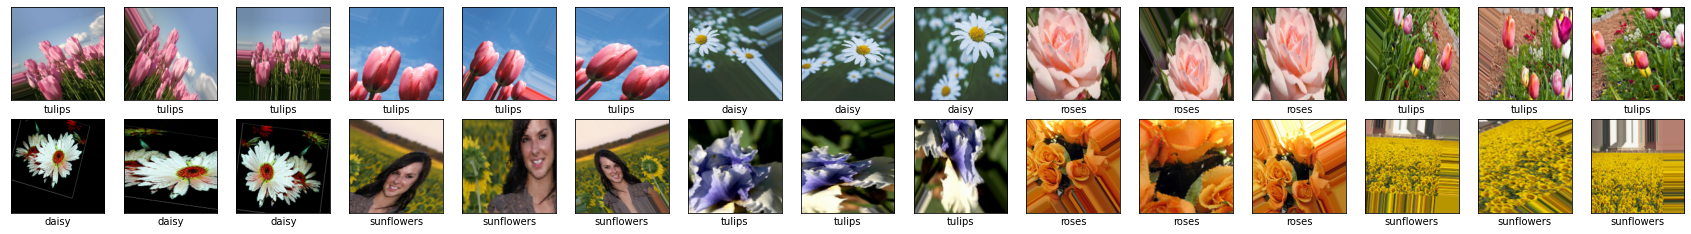

In [ ]:
plt.figure(figsize=(30, 10))
for flower_index in range(30):
  plt.subplot(5, 15, flower_index+1)

  flower_index = int(flower_index/3)
  image = train_data_gen[0][0][flower_index]
  label = get_label(train_data_gen[0][1][flower_index])

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label)
plt.show()

In [ ]:
test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_gen.flow_from_directory(
    test_dir, 
    target_size=TARGET_IMAGE_SHAPE, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

Found 731 images belonging to 5 classes.


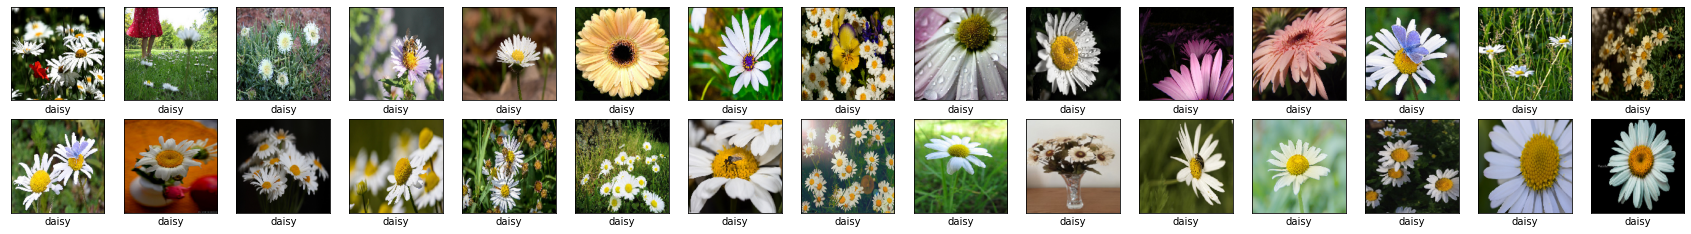

In [ ]:
plt.figure(figsize=(30, 10))
for flower_index in range(30):
  image = test_data_gen[0][0][flower_index]
  label = get_label(test_data_gen[0][1][flower_index])

  plt.subplot(5, 15, flower_index+1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label)
plt.show()

# Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax'),
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [ ]:
EPOCHS=100
history = model.fit_generator(
    train_data_gen, 
    epochs=EPOCHS,
    steps_per_epoch=int(np.ceil(N_TRAIN/BATCH_SIZE)),
    validation_data=test_data_gen,
    validation_steps=int(np.ceil(N_TEST/ BATCH_SIZE))
  )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


30/30 [==============================] - 54s 718ms/step - loss: 1.4721 - accuracy: 0.3620 - val_loss: 1.1540 - val_accuracy: 0.5294
Epoch 2/100
30/30 [==============================] - 21s 708ms/step - loss: 1.1556 - accuracy: 0.5206 - val_loss: 1.0592 - val_accuracy: 0.5677
Epoch 3/100
30/30 [==============================] - 21s 696ms/step - loss: 1.0690 - accuracy: 0.5737 - val_loss: 1.0526 - val_accuracy: 0.6005
Epoch 4/100
30/30 [==============================] - 21s 691ms/step - loss: 1.0056 - accuracy: 0.6087 - val_loss: 0.9372 - val_accuracy: 0.6375
Epoch 5/100
30/30 [==============================] - 21s 698ms/step - loss: 0.9931 - accuracy: 0.6039 - val_loss: 0.9382 - val_accuracy: 0.6265
Epoch 6/100
30/30 [==============================] - 21s 695ms/step - loss: 0.9291 - accuracy: 0.6325 - val_loss: 0.8554 - val_accuracy: 0.6553
Epoch 7/100
30/30 [==============================] - 21s 694ms/step - loss: 0.8822 - accuracy: 0.6553 - val_loss: 0.9059 - val_accuracy: 0.6621
Epoc

Text(0.5, 1.0, 'Loss')

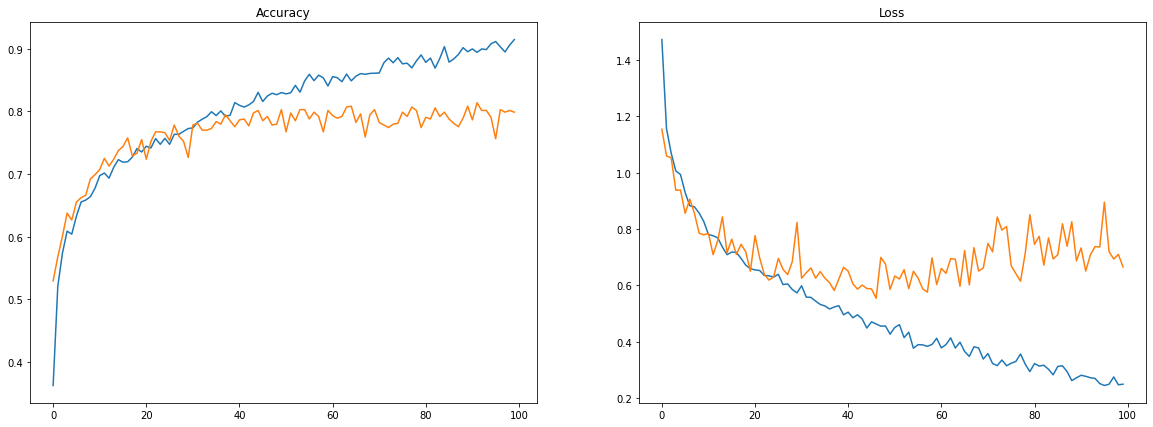

In [ ]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['accuracy'],label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], label='Test')
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['loss'],label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.title("Loss")

daisy
daisy
daisy
daisy
daisy


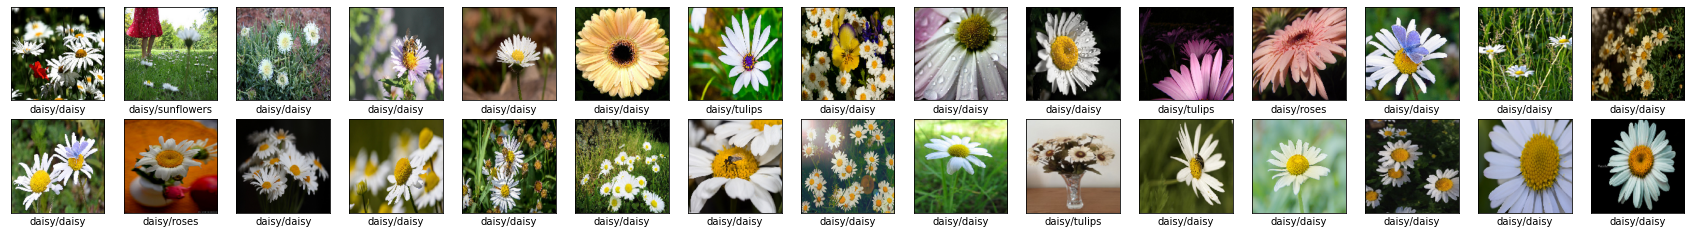

In [ ]:
test_data_gen.shuffle = False
test_data_gen.reset()

predictions = model.predict(test_data_gen)
predictions.shape
print(get_label(test_data_gen[0][1][0]))
print(get_label(test_data_gen[0][1][1]))
print(get_label(test_data_gen[0][1][2]))
print(get_label(test_data_gen[0][1][3]))
print(get_label(test_data_gen[0][1][4]))
plt.figure(figsize=(30, 10))
for flower_index in range(30):
  image = test_data_gen[0][0][flower_index]
  label = get_label(test_data_gen[0][1][flower_index])

  prediction = get_label(predictions[flower_index])

  plt.subplot(5, 15, flower_index+1)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label + "/" + prediction)
plt.show()